## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of         depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0           1     13.965021     717.887954   -32.080993      -6.880394   
1           2     13.965021     717.887954   -32.080993      -6.880394   
2           3     13.965021     717.887954   -32.080993      -6.880394   
3           4     13.965021     717.887954   -32.080993      -6.880394   
4           5     13.965021     717.887954   -32.080993      -6.880394   
...       ...           ...            ...          ...            ...   
495570     21     17.945001     796.182785   -59.448422     -13.843945   
495571     22     17.945001     796.182785   -59.448422     -13.843945   
495572     23     17.945001     796.182785   -59.448422     -13.843945   
495573     24     17.945001     796.182785   -59.448422     -13.843945   
495574     25     17.945001     796.182785   -59.448422     -13.843945   

        Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0                

In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 19823
Number of training points: 297325


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix03']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(297325, 23)
(198250, 23)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [20]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [21]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [22]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [23]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [24]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0018987029
RMSE of after m1 0.007228111
RMSE of after m2 0.023938864
RMSE of after m3 0.02434593
RMSE of after m4 0.024347665
RMSE of after m0 0.0017609308
RMSE of after m1 0.01561268
RMSE of after m2 0.114945896
RMSE of after m3 0.114976674
RMSE of after m4 0.11498148
RMSE of after m0 0.0013842721
RMSE of after m1 0.009435397
RMSE of after m2 0.046086617
RMSE of after m3 0.046124697
RMSE of after m4 0.046115737
RMSE of after m0 0.0017147273
RMSE of after m1 0.008467855
RMSE of after m2 0.046246048
RMSE of after m3 0.047490332
RMSE of after m4 0.04750018
RMSE of after m0 0.0020129106
RMSE of after m1 0.00924218
RMSE of after m2 0.02640649
RMSE of after m3 0.02915385
RMSE of after m4 0.029179655
RMSE of after m0 0.0015240337
RMSE of after m1 0.0056566345
RMSE of after m2 0.013815532
RMSE of after m3 0.014077188
RMSE of after m4 0.014113789
RMSE of after m0 0.0014777486
RMSE of after m1 0.008414377
RMSE of after m2 0.053333074
RMSE of after m3 0.053394098
RMSE of after

RMSE of after m1 0.008682527
RMSE of after m2 0.016183915
RMSE of after m3 0.017235706
RMSE of after m4 0.017222237
RMSE of after m0 0.0010824098
RMSE of after m1 0.00608306
RMSE of after m2 0.016380476
RMSE of after m3 0.017887462
RMSE of after m4 0.017884992
RMSE of after m0 0.0013116983
RMSE of after m1 0.009599426
RMSE of after m2 0.06056522
RMSE of after m3 0.06126237
RMSE of after m4 0.061254334
RMSE of after m0 0.0016692464
RMSE of after m1 0.007697361
RMSE of after m2 0.02233453
RMSE of after m3 0.027155563
RMSE of after m4 0.027120681
RMSE of after m0 0.0014332477
RMSE of after m1 0.007595434
RMSE of after m2 0.033235025
RMSE of after m3 0.035592683
RMSE of after m4 0.035563998
RMSE of after m0 0.0010906997
RMSE of after m1 0.0061691017
RMSE of after m2 0.016234374
RMSE of after m3 0.017008966
RMSE of after m4 0.016982272
RMSE of after m0 0.0011896436
RMSE of after m1 0.006097947
RMSE of after m2 0.020874735
RMSE of after m3 0.02213975
RMSE of after m4 0.022097908
RMSE of afte

RMSE of after m0 0.0014436321
RMSE of after m1 0.021203069
RMSE of after m2 0.17642437
RMSE of after m3 0.17634007
RMSE of after m4 0.17632818
RMSE of after m0 0.0014676702
RMSE of after m1 0.014479118
RMSE of after m2 0.059701666
RMSE of after m3 0.060220566
RMSE of after m4 0.060199384
RMSE of after m0 0.0014128822
RMSE of after m1 0.00936586
RMSE of after m2 0.024120588
RMSE of after m3 0.025134066
RMSE of after m4 0.025112538
RMSE of after m0 0.0012307038
RMSE of after m1 0.007537169
RMSE of after m2 0.017852666
RMSE of after m3 0.018357312
RMSE of after m4 0.018353192
RMSE of after m0 0.0012283346
RMSE of after m1 0.0058335457
RMSE of after m2 0.014492294
RMSE of after m3 0.0153557705
RMSE of after m4 0.015355758
RMSE of after m0 0.0011161059
RMSE of after m1 0.007406144
RMSE of after m2 0.033299837
RMSE of after m3 0.033730768
RMSE of after m4 0.033726934
RMSE of after m0 0.001228216
RMSE of after m1 0.0075292466
RMSE of after m2 0.038226556
RMSE of after m3 0.038894914
RMSE of a

RMSE of after m4 0.057207353
RMSE of after m0 0.0014505128
RMSE of after m1 0.006377477
RMSE of after m2 0.018208133
RMSE of after m3 0.019385658
RMSE of after m4 0.019404
RMSE of after m0 0.0014146554
RMSE of after m1 0.0054878592
RMSE of after m2 0.021077454
RMSE of after m3 0.021762075
RMSE of after m4 0.021775687
RMSE of after m0 0.0015758397
RMSE of after m1 0.011476513
RMSE of after m2 0.0667426
RMSE of after m3 0.06754021
RMSE of after m4 0.06754381
RMSE of after m0 0.0012472911
RMSE of after m1 0.007169062
RMSE of after m2 0.022311663
RMSE of after m3 0.022560144
RMSE of after m4 0.022570742
RMSE of after m0 0.0012032384
RMSE of after m1 0.006666627
RMSE of after m2 0.02774897
RMSE of after m3 0.027904028
RMSE of after m4 0.027914934
RMSE of after m0 0.0011186904
RMSE of after m1 0.006248001
RMSE of after m2 0.028134406
RMSE of after m3 0.028443215
RMSE of after m4 0.028448207
RMSE of after m0 0.001319188
RMSE of after m1 0.013160479
RMSE of after m2 0.0864452
RMSE of after m3 

RMSE of after m1 0.008652197
RMSE of after m2 0.041783474
RMSE of after m3 0.041863635
RMSE of after m4 0.041868817
RMSE of after m0 0.0012780824
RMSE of after m1 0.010466617
RMSE of after m2 0.064032294
RMSE of after m3 0.06408443
RMSE of after m4 0.06409554
RMSE of after m0 0.0013225102
RMSE of after m1 0.010170479
RMSE of after m2 0.05304985
RMSE of after m3 0.0534788
RMSE of after m4 0.05349308
RMSE of after m0 0.0015288171
RMSE of after m1 0.0077214497
RMSE of after m2 0.02807182
RMSE of after m3 0.031140288
RMSE of after m4 0.031147908
RMSE of after m0 0.0013643036
RMSE of after m1 0.009258186
RMSE of after m2 0.040581726
RMSE of after m3 0.04086503
RMSE of after m4 0.040867694
RMSE of after m0 0.0012993767
RMSE of after m1 0.010612593
RMSE of after m2 0.07488394
RMSE of after m3 0.0752043
RMSE of after m4 0.075211495
RMSE of after m0 0.0013933148
RMSE of after m1 0.010225782
RMSE of after m2 0.027365511
RMSE of after m3 0.028718285
RMSE of after m4 0.02871299
RMSE of after m0 0.

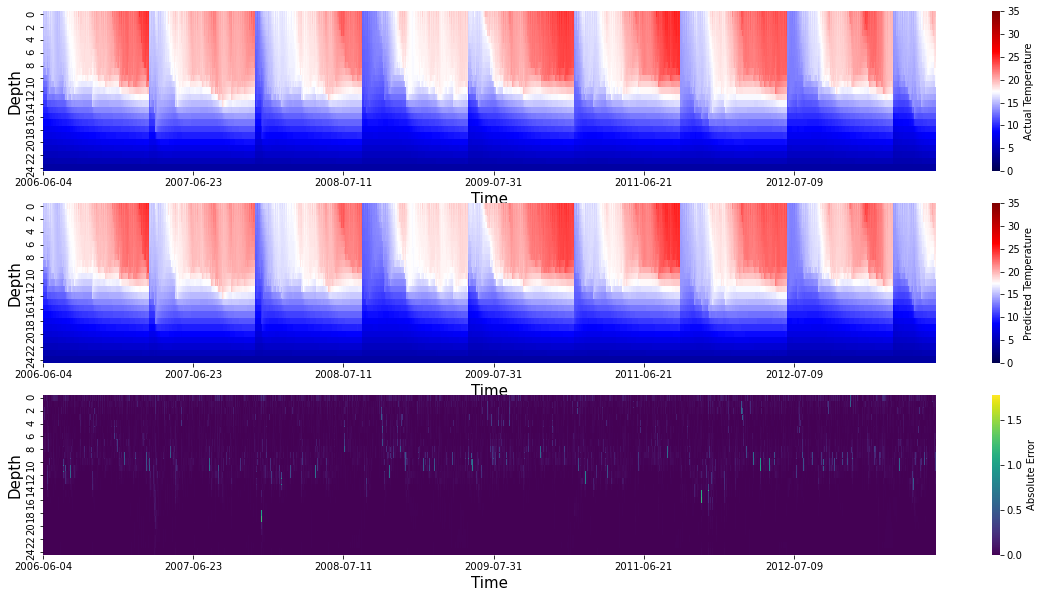

In [25]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

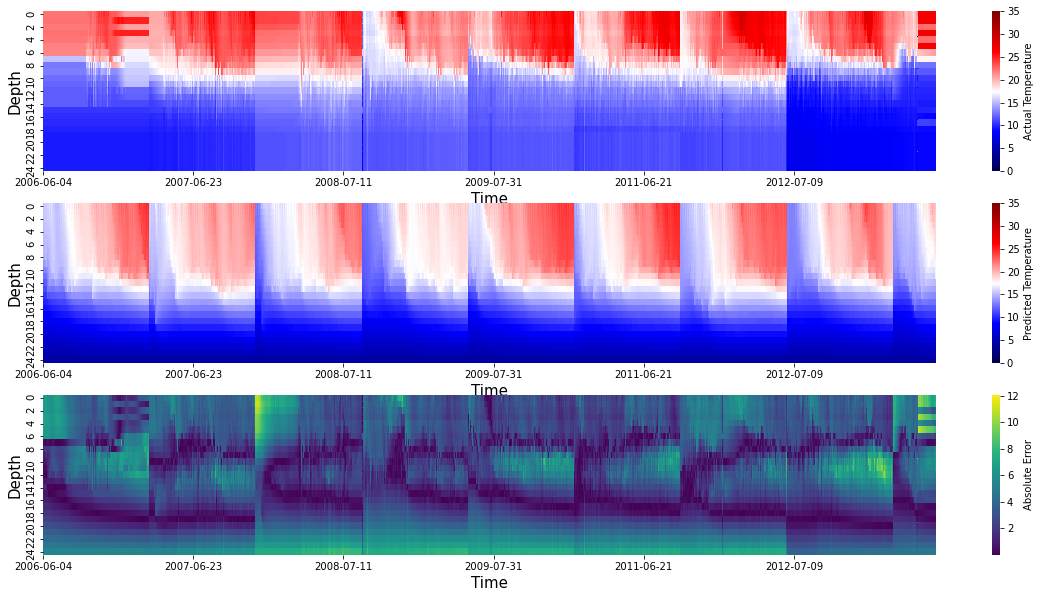

In [26]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [27]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0011541428
RMSE of after m1 0.016101565
RMSE of after m2 0.09536987
RMSE of after m3 0.09543229
RMSE of after m4 0.09542019
RMSE of after m0 0.0012884701
RMSE of after m1 0.012483439
RMSE of after m2 0.048801947
RMSE of after m3 0.049057692
RMSE of after m4 0.049076643
RMSE of after m0 0.0013549231
RMSE of after m1 0.012336481
RMSE of after m2 0.06394777
RMSE of after m3 0.06439265
RMSE of after m4 0.06439663
RMSE of after m0 0.001573939
RMSE of after m1 0.008851846
RMSE of after m2 0.025957342
RMSE of after m3 0.031159176
RMSE of after m4 0.031139994
RMSE of after m0 0.0014333202
RMSE of after m1 0.0115318345
RMSE of after m2 0.07240617
RMSE of after m3 0.07389846
RMSE of after m4 0.07389637
RMSE of after m0 0.0013656919
RMSE of after m1 0.0100127235
RMSE of after m2 0.033582658
RMSE of after m3 0.034195893
RMSE of after m4 0.034216214
RMSE of after m0 0.0011776322
RMSE of after m1 0.011196873
RMSE of after m2 0.060541578
RMSE of after m3 0.060778193
RMSE of after m

RMSE of after m1 0.00901299
RMSE of after m2 0.039287943
RMSE of after m3 0.03938798
RMSE of after m4 0.039386224
RMSE of after m0 0.0012099098
RMSE of after m1 0.0066697504
RMSE of after m2 0.026316727
RMSE of after m3 0.02651969
RMSE of after m4 0.026527869
RMSE of after m0 0.0011733468
RMSE of after m1 0.008269353
RMSE of after m2 0.04095567
RMSE of after m3 0.041046374
RMSE of after m4 0.041052252
RMSE of after m0 0.00119227
RMSE of after m1 0.011672054
RMSE of after m2 0.05448863
RMSE of after m3 0.054763343
RMSE of after m4 0.054760024
RMSE of after m0 0.001180947
RMSE of after m1 0.0085955635
RMSE of after m2 0.031038353
RMSE of after m3 0.031313583
RMSE of after m4 0.03131362
RMSE of after m0 0.0012129402
RMSE of after m1 0.006806074
RMSE of after m2 0.016430771
RMSE of after m3 0.017672477
RMSE of after m4 0.017683484
RMSE of after m0 0.0013220266
RMSE of after m1 0.013557732
RMSE of after m2 0.08054463
RMSE of after m3 0.08064338
RMSE of after m4 0.08064236
RMSE of after m0 0

RMSE of after m0 0.0013332223
RMSE of after m1 0.013201491
RMSE of after m2 0.042897504
RMSE of after m3 0.043050446
RMSE of after m4 0.04304219
RMSE of after m0 0.0012206625
RMSE of after m1 0.010568687
RMSE of after m2 0.055941854
RMSE of after m3 0.056151498
RMSE of after m4 0.05614698
RMSE of after m0 0.0017058859
RMSE of after m1 0.012309212
RMSE of after m2 0.07417599
RMSE of after m3 0.074246615
RMSE of after m4 0.07424026
RMSE of after m0 0.0016787444
RMSE of after m1 0.009799123
RMSE of after m2 0.047431227
RMSE of after m3 0.04745922
RMSE of after m4 0.04747451
RMSE of after m0 0.0012147137
RMSE of after m1 0.008265454
RMSE of after m2 0.03288612
RMSE of after m3 0.032821577
RMSE of after m4 0.032834623
RMSE of after m0 0.001075866
RMSE of after m1 0.007987612
RMSE of after m2 0.047834273
RMSE of after m3 0.04794704
RMSE of after m4 0.04793424
RMSE of after m0 0.0011435029
RMSE of after m1 0.009720424
RMSE of after m2 0.032231335
RMSE of after m3 0.0326585
RMSE of after m4 0.

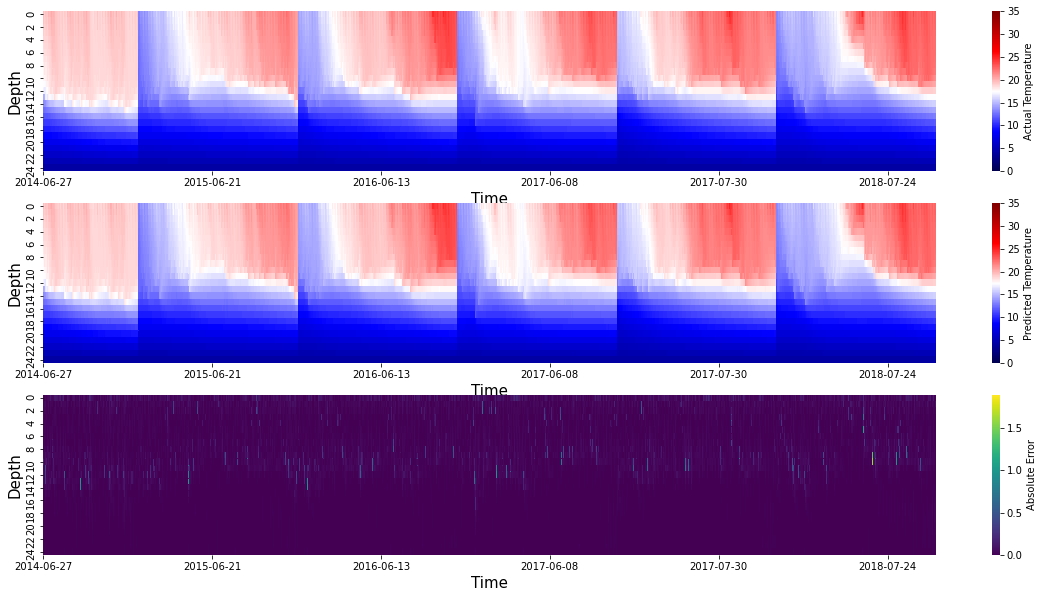

In [28]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

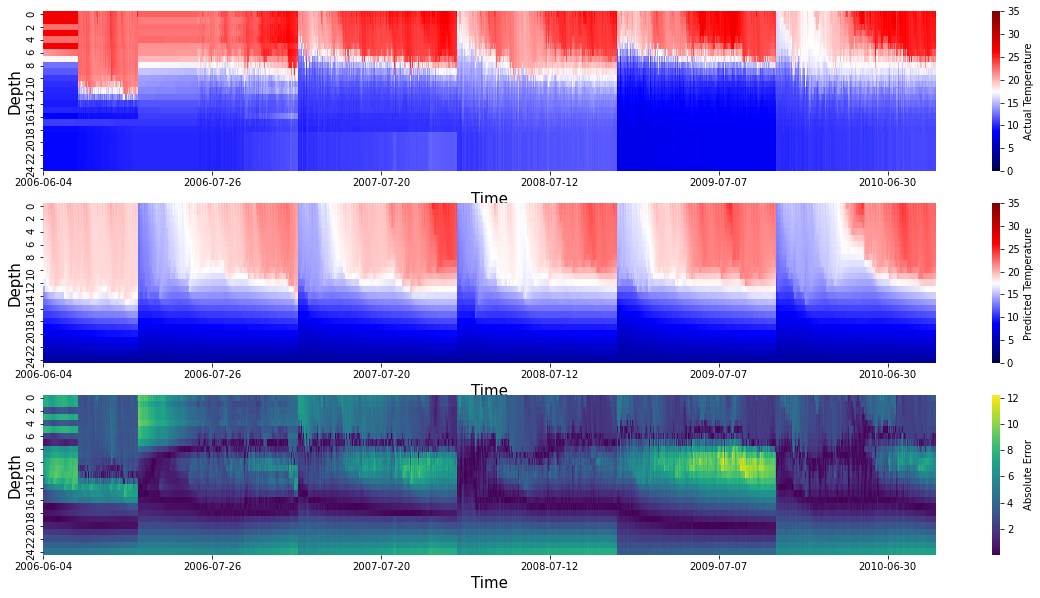

In [29]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [30]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 12.78374249688134, Train L2 Error: 0.8337427173504972
Test RMSE: 12.898444002772136, Train L2 Error: 0.8351028717356513


## Mixing Model

In [31]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04697958908507593, Train L2 Error: 0.0030637252879735055
Test RMSE: 0.04598526649073426, Train L2 Error: 0.0029770726607876415


## Convection Model

In [32]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.004543179681784685, Train L2 Error: 0.0002962804739826945
Test RMSE: 0.004928978264442002, Train L2 Error: 0.00031910286552458325


## Ice Model

In [33]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.00020992106922037695, Train L2 Error: 1.3689864421812881e-05
Test RMSE: 0.00021575026316656776, Train L2 Error: 1.3967707610073765e-05


# Finetuning

In [34]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [35]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [36]:
#freeze_model(heating_model)
freeze_model(heating_model)
freeze_model(heat_diff_model)
freeze_model(mixing_model)
freeze_model(convection_model)
unfreeze_model(ice_model)


# Finetuning on Observed Temperature

In [37]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:03<26:40,  3.21s/it]

Epoch : 0, Train_loss: 0.42832617436679415, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.42832617436679415


 10%|█         | 51/500 [02:47<27:38,  3.69s/it]

Epoch : 50, Train_loss: 0.11348786237555862, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.11348786237555862


 20%|██        | 101/500 [05:54<25:21,  3.81s/it]

Epoch : 100, Train_loss: 0.10379203582720069, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.10379203582720069


 30%|███       | 151/500 [10:26<27:43,  4.77s/it]

Epoch : 150, Train_loss: 0.10118409938760252, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.10118409938760252


 40%|████      | 201/500 [14:14<19:09,  3.84s/it]

Epoch : 200, Train_loss: 0.09944647620588341, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.09944647620588341


 50%|█████     | 251/500 [17:26<17:08,  4.13s/it]

Epoch : 250, Train_loss: 0.097995689548177, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.097995689548177


 60%|██████    | 301/500 [20:40<12:56,  3.90s/it]

Epoch : 300, Train_loss: 0.09669477325057824, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.09669477325057824


 70%|███████   | 351/500 [23:47<09:32,  3.84s/it]

Epoch : 350, Train_loss: 0.09550292191139403, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.09550292191139403


 80%|████████  | 401/500 [26:52<05:56,  3.61s/it]

Epoch : 400, Train_loss: 0.09440543369746349, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.09440543369746349


 90%|█████████ | 451/500 [30:00<02:51,  3.50s/it]

Epoch : 450, Train_loss: 0.09339567796395928, Loss m0: 6.833796524636602e-08, Loss m1: 2.8556008271683723e-06, Loss m2: 8.188639416580036e-05, Loss m3: 8.371914534426645e-05, Loss m4: 0.09339567796395928


100%|██████████| 500/500 [33:00<00:00,  3.96s/it]


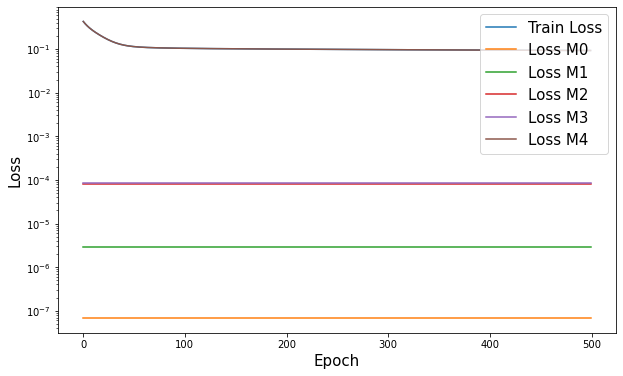

In [38]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [39]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0018987029
RMSE of after m1 0.007228111
RMSE of after m2 0.023938864
RMSE of after m3 0.02434593
RMSE of after m4 3.3836632
RMSE of after m0 0.0017609308
RMSE of after m1 0.01561268
RMSE of after m2 0.114945896
RMSE of after m3 0.114976674
RMSE of after m4 3.3727486
RMSE of after m0 0.0013842721
RMSE of after m1 0.009435397
RMSE of after m2 0.046086617
RMSE of after m3 0.046124697
RMSE of after m4 3.347686
RMSE of after m0 0.0017147273
RMSE of after m1 0.008467855
RMSE of after m2 0.046246048
RMSE of after m3 0.047490332
RMSE of after m4 3.3130429
RMSE of after m0 0.0020129106
RMSE of after m1 0.00924218
RMSE of after m2 0.02640649
RMSE of after m3 0.02915385
RMSE of after m4 3.3490434
RMSE of after m0 0.0015240337
RMSE of after m1 0.0056566345
RMSE of after m2 0.013815532
RMSE of after m3 0.014077188
RMSE of after m4 3.3258283
RMSE of after m0 0.0014777486
RMSE of after m1 0.008414377
RMSE of after m2 0.053333074
RMSE of after m3 0.053394098
RMSE of after m4 3.26929

RMSE of after m0 0.0011978961
RMSE of after m1 0.008682527
RMSE of after m2 0.016183915
RMSE of after m3 0.017235706
RMSE of after m4 3.5330505
RMSE of after m0 0.0010824098
RMSE of after m1 0.00608306
RMSE of after m2 0.016380476
RMSE of after m3 0.017887462
RMSE of after m4 3.4249122
RMSE of after m0 0.0013116983
RMSE of after m1 0.009599426
RMSE of after m2 0.06056522
RMSE of after m3 0.06126237
RMSE of after m4 3.3692296
RMSE of after m0 0.0016692464
RMSE of after m1 0.007697361
RMSE of after m2 0.02233453
RMSE of after m3 0.027155563
RMSE of after m4 3.4326065
RMSE of after m0 0.0014332477
RMSE of after m1 0.007595434
RMSE of after m2 0.033235025
RMSE of after m3 0.035592683
RMSE of after m4 3.3663816
RMSE of after m0 0.0010906997
RMSE of after m1 0.0061691017
RMSE of after m2 0.016234374
RMSE of after m3 0.017008966
RMSE of after m4 3.3240201
RMSE of after m0 0.0011896436
RMSE of after m1 0.006097947
RMSE of after m2 0.020874735
RMSE of after m3 0.02213975
RMSE of after m4 3.2899

RMSE of after m0 0.0016305727
RMSE of after m1 0.01042457
RMSE of after m2 0.034630973
RMSE of after m3 0.0379913
RMSE of after m4 3.1988118
RMSE of after m0 0.0012767762
RMSE of after m1 0.0066401423
RMSE of after m2 0.012674521
RMSE of after m3 0.013403348
RMSE of after m4 3.1264672
RMSE of after m0 0.0011093977
RMSE of after m1 0.0065409895
RMSE of after m2 0.030394178
RMSE of after m3 0.03089605
RMSE of after m4 3.044172
RMSE of after m0 0.0011544292
RMSE of after m1 0.0057771667
RMSE of after m2 0.026068121
RMSE of after m3 0.027566832
RMSE of after m4 2.999995
RMSE of after m0 0.0013439296
RMSE of after m1 0.010926548
RMSE of after m2 0.08351856
RMSE of after m3 0.08399738
RMSE of after m4 2.9857829
RMSE of after m0 0.001135159
RMSE of after m1 0.009652985
RMSE of after m2 0.044495694
RMSE of after m3 0.04502384
RMSE of after m4 3.0834892
RMSE of after m0 0.0013715677
RMSE of after m1 0.007092962
RMSE of after m2 0.025838964
RMSE of after m3 0.02764031
RMSE of after m4 3.0854871


RMSE of after m1 0.0059945183
RMSE of after m2 0.022507055
RMSE of after m3 0.022953246
RMSE of after m4 3.1852136
RMSE of after m0 0.00090591377
RMSE of after m1 0.0048547257
RMSE of after m2 0.031390056
RMSE of after m3 0.031457074
RMSE of after m4 3.1073582
RMSE of after m0 0.001040875
RMSE of after m1 0.0112302
RMSE of after m2 0.08302619
RMSE of after m3 0.08307543
RMSE of after m4 3.131951
RMSE of after m0 0.0010972169
RMSE of after m1 0.007408964
RMSE of after m2 0.02975962
RMSE of after m3 0.030294325
RMSE of after m4 3.1485224
RMSE of after m0 0.0012939358
RMSE of after m1 0.007677812
RMSE of after m2 0.019964954
RMSE of after m3 0.022678649
RMSE of after m4 3.147761
RMSE of after m0 0.0012560833
RMSE of after m1 0.0069809076
RMSE of after m2 0.01863506
RMSE of after m3 0.021690572
RMSE of after m4 3.1438491
RMSE of after m0 0.0009816784
RMSE of after m1 0.007999009
RMSE of after m2 0.034753386
RMSE of after m3 0.0350569
RMSE of after m4 3.1373498
RMSE of after m0 0.0013989409

RMSE of after m3 0.024089068
RMSE of after m4 3.175097
RMSE of after m0 0.0013939807
RMSE of after m1 0.0074348543
RMSE of after m2 0.026862111
RMSE of after m3 0.027382385
RMSE of after m4 3.1810386
RMSE of after m0 0.0017292452
RMSE of after m1 0.0143339485
RMSE of after m2 0.09126442
RMSE of after m3 0.091403686
RMSE of after m4 3.204419
RMSE of after m0 0.0016158349
RMSE of after m1 0.00928253
RMSE of after m2 0.041529007
RMSE of after m3 0.04197657
RMSE of after m4 3.170337
RMSE of after m0 0.0012978519
RMSE of after m1 0.009128234
RMSE of after m2 0.041630413
RMSE of after m3 0.04185062
RMSE of after m4 3.162857
RMSE of after m0 0.0010822562
RMSE of after m1 0.008257082
RMSE of after m2 0.061177474
RMSE of after m3 0.06134047
RMSE of after m4 3.0998487
RMSE of after m0 0.0011623073
RMSE of after m1 0.011895893
RMSE of after m2 0.043095395
RMSE of after m3 0.043018874
RMSE of after m4 3.165103
RMSE of after m0 0.0013045014
RMSE of after m1 0.011830443
RMSE of after m2 0.06541946
R

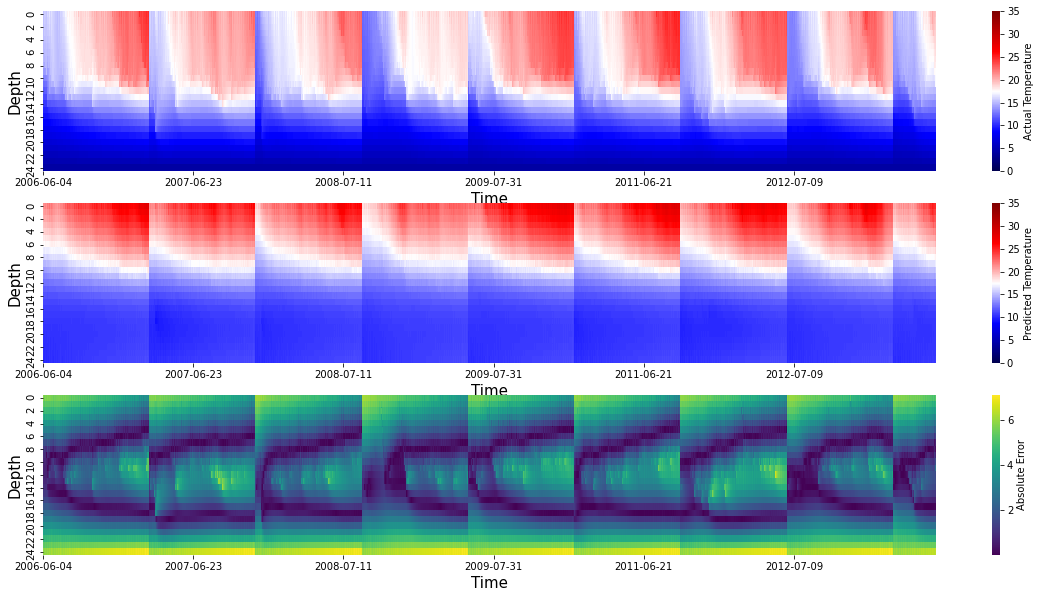

In [40]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

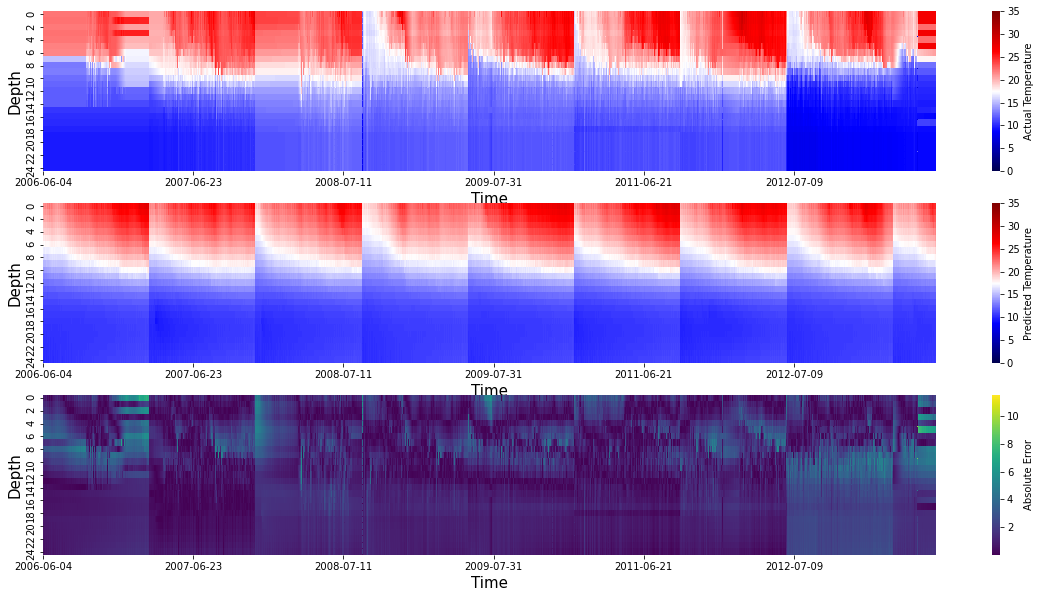

In [41]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [42]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0011541428
RMSE of after m1 0.016101565
RMSE of after m2 0.09536987
RMSE of after m3 0.09543229
RMSE of after m4 3.1400769
RMSE of after m0 0.0012884701
RMSE of after m1 0.012483439
RMSE of after m2 0.048801947
RMSE of after m3 0.049057692
RMSE of after m4 3.321162
RMSE of after m0 0.0013549231
RMSE of after m1 0.012336481
RMSE of after m2 0.06394777
RMSE of after m3 0.06439265
RMSE of after m4 3.4195077
RMSE of after m0 0.001573939
RMSE of after m1 0.008851846
RMSE of after m2 0.025957342
RMSE of after m3 0.031159176
RMSE of after m4 3.4365125
RMSE of after m0 0.0014333202
RMSE of after m1 0.0115318345
RMSE of after m2 0.07240617
RMSE of after m3 0.07389846
RMSE of after m4 3.3796165
RMSE of after m0 0.0013656919
RMSE of after m1 0.0100127235
RMSE of after m2 0.033582658
RMSE of after m3 0.034195893
RMSE of after m4 3.4612036
RMSE of after m0 0.0011776322
RMSE of after m1 0.011196873
RMSE of after m2 0.060541578
RMSE of after m3 0.060778193
RMSE of after m4 3.475418

RMSE of after m1 0.0066697504
RMSE of after m2 0.026316727
RMSE of after m3 0.02651969
RMSE of after m4 3.0994875
RMSE of after m0 0.0011733468
RMSE of after m1 0.008269353
RMSE of after m2 0.04095567
RMSE of after m3 0.041046374
RMSE of after m4 3.0631638
RMSE of after m0 0.00119227
RMSE of after m1 0.011672054
RMSE of after m2 0.05448863
RMSE of after m3 0.054763343
RMSE of after m4 3.1190994
RMSE of after m0 0.001180947
RMSE of after m1 0.0085955635
RMSE of after m2 0.031038353
RMSE of after m3 0.031313583
RMSE of after m4 3.1370344
RMSE of after m0 0.0012129402
RMSE of after m1 0.006806074
RMSE of after m2 0.016430771
RMSE of after m3 0.017672477
RMSE of after m4 3.1156292
RMSE of after m0 0.0013220266
RMSE of after m1 0.013557732
RMSE of after m2 0.08054463
RMSE of after m3 0.08064338
RMSE of after m4 3.199549
RMSE of after m0 0.0012279205
RMSE of after m1 0.00876306
RMSE of after m2 0.028006213
RMSE of after m3 0.028511014
RMSE of after m4 3.2608418
RMSE of after m0 0.0014105397


RMSE of after m1 0.008641134
RMSE of after m2 0.029505815
RMSE of after m3 0.030165441
RMSE of after m4 3.5819256
RMSE of after m0 0.0014889527
RMSE of after m1 0.008211875
RMSE of after m2 0.023133233
RMSE of after m3 0.02328755
RMSE of after m4 3.495518
RMSE of after m0 0.0014912321
RMSE of after m1 0.009699809
RMSE of after m2 0.047740817
RMSE of after m3 0.04780709
RMSE of after m4 3.4273217
RMSE of after m0 0.0015253456
RMSE of after m1 0.012889215
RMSE of after m2 0.08471043
RMSE of after m3 0.0847443
RMSE of after m4 3.3868988
RMSE of after m0 0.0013332223
RMSE of after m1 0.013201491
RMSE of after m2 0.042897504
RMSE of after m3 0.043050446
RMSE of after m4 3.3708415
RMSE of after m0 0.0012206625
RMSE of after m1 0.010568687
RMSE of after m2 0.055941854
RMSE of after m3 0.056151498
RMSE of after m4 3.3123689
RMSE of after m0 0.0017058859
RMSE of after m1 0.012309212
RMSE of after m2 0.07417599
RMSE of after m3 0.074246615
RMSE of after m4 3.277059
RMSE of after m0 0.0016787444


RMSE of after m0 0.0013018679
RMSE of after m1 0.012584759
RMSE of after m2 0.069497555
RMSE of after m3 0.07008935
RMSE of after m4 3.3093858
RMSE of after m0 0.00114537
RMSE of after m1 0.009856698
RMSE of after m2 0.023407398
RMSE of after m3 0.024042653
RMSE of after m4 3.3775532
RMSE of after m0 0.0015737303
RMSE of after m1 0.008436179
RMSE of after m2 0.025754122
RMSE of after m3 0.02791039
RMSE of after m4 3.376303
RMSE of after m0 0.0016459344
RMSE of after m1 0.007399033
RMSE of after m2 0.01494119
RMSE of after m3 0.021382097
RMSE of after m4 3.3467188
RMSE of after m0 0.0012389956
RMSE of after m1 0.0062848576
RMSE of after m2 0.013686303
RMSE of after m3 0.014477508
RMSE of after m4 3.2636101
Test RMSE Simulated: 3.24330735206604
Test RMSE Observed Temp: 1.951856255531311
test L2 Error: 0.19770307838916779
The RMSEs after each modelling stage: [1.40803191e-03 9.18628187e-03 4.28098982e-02 4.37213577e-02
 3.23953307e+00]


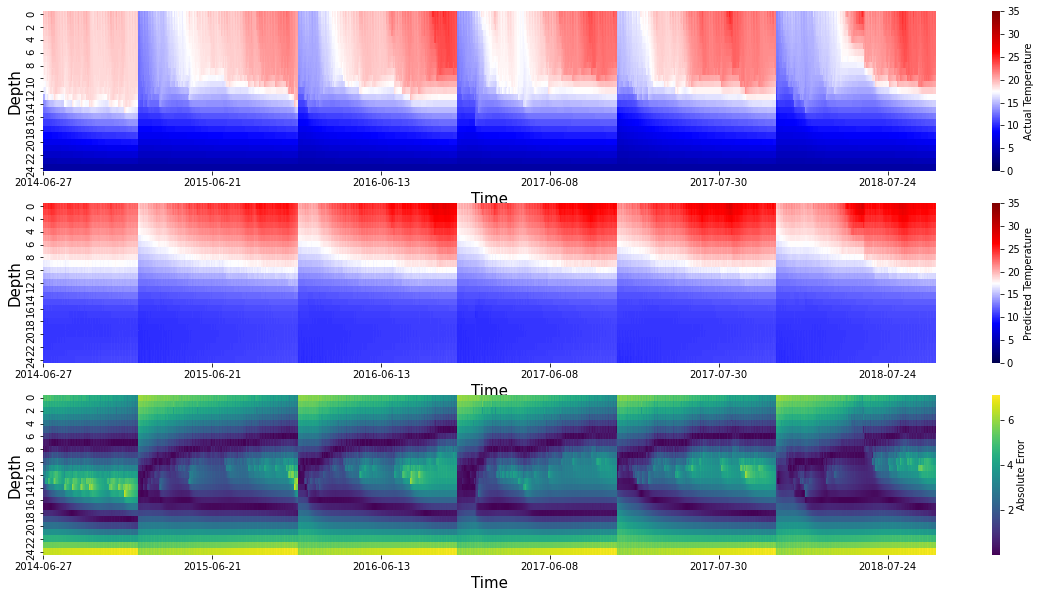

In [43]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

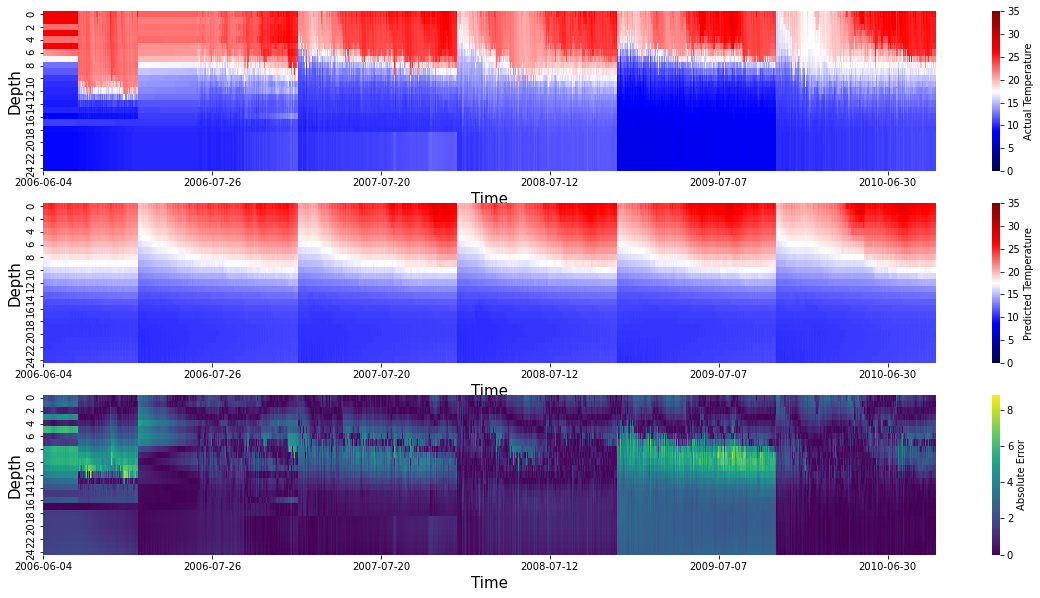

In [44]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [45]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 12.78374249688134, Train L2 Error: 0.8337427173504972
Test RMSE: 12.898444002772136, Train L2 Error: 0.8351028717356513


## Mixing Model

In [46]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04697958908507593, Train L2 Error: 0.0030637252879735055
Test RMSE: 0.04598526649073426, Train L2 Error: 0.0029770726607876415


## Convection Model

In [47]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.004543179681784685, Train L2 Error: 0.0002962804739826945
Test RMSE: 0.004928978264442002, Train L2 Error: 0.00031910286552458325


## Ice Model

In [48]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 3.254147855614133, Train L2 Error: 0.21221711149500117
Test RMSE: 3.2437946847414634, Train L2 Error: 0.2100038027235234


# Compute Model Similarity after Finetuning

In [49]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [50]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [51]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [52]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [53]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [54]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.912380039691925
L2 Norm: 2.850107192993164


In [55]:
# Freeze all models again and compute finetuned diffusivity values

In [56]:
#freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)
freeze_model(heat_diff_model)
freeze_model(heating_model)

In [57]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

diffusivity = []

for ix, x in enumerate(iter(train_loader)):
    x = x.to(device).float()
    optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
    m0_input = x[:, m0_input_column_ix]
        
        #model 0
    m0_pred = heating_model(m0_input) #predicts diff and temp
    loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
    m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
    proj = heat_diff_model(m1_input)
    pred = implicit_diffusion(proj, m0_pred)        
    m1_pred = pred.to(dtype=torch.float32)
    

                
    loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
    diffusivity.append(proj)

    

diffusivity_ = torch.cat(diffusivity, dim=0) 
    
        


#diffusivity_ = diffusivity_.flatten().detach().cpu().numpy()
#print(diffusivity_.shape)
    
#diffusivity_ = np.reshape(diffusivity_, (diffusivity_.shape[0]//depth_steps, depth_steps))

#print(diffusivity_.shape)

(297325,)
-1.3072822e-06
-5.3028725e-06
[3.73840547e-05]
[2.51789534e-06]
298
(297325, 23)
(297325,)
[0]
(297325, 1)
[-1.66410059]
<bound method NDFrame.head of            depth  diffusivity_finetuned
0      -1.664101              -2.099827
1      -1.525426              -2.093076
2      -1.386750              -2.093163
3      -1.248075              -2.095328
4      -1.109400              -2.098037
...          ...                    ...
297320  1.109400              -2.096586
297321  1.248075              -2.096830
297322  1.386750              -2.098312
297323  1.525426              -2.096514
297324  1.664101              -2.097793

[297325 rows x 2 columns]>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297325 entries, 0 to 297324
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   depth                  297325 non-null  float64
 1   diffusivity_finetuned  297325 non-null  float32
dtypes: f

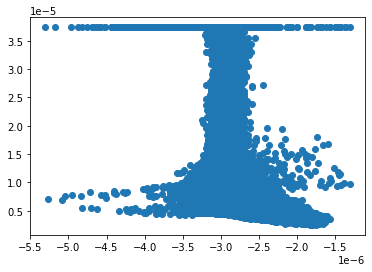

In [58]:
torch.save(diffusivity, 'diffusivity.t')


diffusivity_ = torch.cat(diffusivity, dim=0) 
diffusivity_ = diffusivity_.flatten().detach().cpu().numpy()
print(diffusivity_.shape)

#print(train_data.shape)
#print(data_df.shape)

diff_input_columns = [ 'diffusivity']

diff_input_column_ix = [data_df.columns.get_loc(column) for column in diff_input_columns]

#print(diff_input_column_ix)

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

diff_train = train_data[:, diff_input_column_ix]

#print(std_diff)
#print(mean_diff)

diff_dl = diffusivity_ * 1.0687e-05 + 1.9475e-05
diff_pb = diff_train * 1.0687e-05 + 1.9475e-05

#plt.scatter(diffusivity_ , train_data[:, diff_input_column_ix])
plt.scatter(diff_dl, diff_pb)

print(max(diff_dl))
print(min(diff_dl))

print(max(diff_pb))
print(min(diff_pb))

print(len(diffusivity))
print(train_data.shape)
print(diffusivity_.shape)



depth_input_columns = ['depth']
depth_input_column_ix = [data_df.columns.get_loc(column) for column in depth_input_columns]

print(depth_input_column_ix)

depth_df = train_data[:, depth_input_column_ix]
print(depth_df.shape)

test = pd.DataFrame(data={'depth':list(depth_df),
                  'diffusivity_finetuned':diffusivity_[:,]})
print(test['depth'][0])
test['depth'] = test['depth'].astype(float)  

print(test.head)
print(test.info())

#X = train_data.merge(test, how='inner', on=['depth'])
diff_df = test.iloc[:, 1].to_numpy()

print(diff_df[:,].shape)
print(train_data[:,].shape)

df = pd.DataFrame(diffusivity) 
print(len(diffusivity))
print(df.shape)
#print(diffusivity.info())
# saving the dataframe 
df.to_csv('finetuned_diff.csv') 

df2 = pd.DataFrame(diffusivity_) 
#print(diffusivity.info())
# saving the dataframe 
df2.to_csv('finetuned_diff_.csv') 

test_ = torch.cat(diffusivity, dim=0) 
test_ = test_.flatten().detach().cpu().numpy()
print(test_.shape)

def shape(lst):
    length = len(lst)
    shp = tuple(shape(sub) if isinstance(sub, list) else 0 for sub in lst)
    if any(x != 0 for x in shp):
        return length, shp
    else:
        return length
    
print(shape(diffusivity))

print(len(diffusivity[1]))

print(torch.is_tensor(diffusivity))

print(84925/25)

In [59]:
# Unfreeze diffusion model and finetune it on projected diffusivities